In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v1.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2['eGFR_ab30'] = np.where(df2['eGFR_ckd']<30,1,0)
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn,eGFR_ab30
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046,0.014049
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706,0.117692
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000,1.000000


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab30==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         49.94635961 68.85955582 95.        ]
age0_edge: 49.94635960905048 
age1_edge: 68.85955582356871 
age2_edge: 95.0
age group:
 0     466
1    1118
2    1507
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    131133
1     63825
2     25062
Name: level, dtype: int64


In [6]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab30'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.2, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab30']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.2, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab30']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.2, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 49
total cases = 131133
total abnormal function of kidney = 466 
prevalence = 0.35536440102796396
train0 : 373 test0 : 93

age1 50 68
total cases = 63825
total abnormal function of kidney = 1118 
prevalence = 1.7516647081864474
train1 : 894 test1 : 224

age2 69 95
total cases = 25062
total abnormal function of kidney = 1507 
prevalence = 6.013087542893624
train2 : 1206 test2 : 301


In [7]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 3091 
prevalence = 1.4048722843377874


In [7]:
# for psm 
#X_test.to_csv("~/proj_ua/data/cha_test_psm.csv", index=False)

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

176015 train cases, 12 variables
44005 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,176015.000000,1.760150e+05,1.760150e+05,176015.000000,1.760150e+05,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000,176015.000000
mean,0.429350,2.221872e-16,-3.972241e-16,0.020209,1.692918e-14,0.331227,0.233327,0.205130,0.040014,0.758543,0.167741,0.514490
std,0.494985,1.000003e+00,1.000003e+00,0.140713,1.000003e+00,0.770470,0.887225,0.669495,0.326671,1.254166,0.559464,1.022325
min,0.000000,-1.874471e+00,-1.435462e+00,0.000000,-1.723133e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.822702e-01,-8.282717e-01,0.000000,-1.091191e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.397992e-01,-2.210813e-01,0.000000,1.726920e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.954129e-01,9.932995e-01,0.000000,8.046336e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.072555e+00,3.422061e+00,1.000000,1.436575e+00,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000


In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_30model.v1
model = XGBClassifier(colsample_bytree=0.6000000000000001, gamma=1.0, learning_rate=0.01, max_depth=4, min_child_weight=20, n_estimators=500, 
                      objective="binary:logistic", reg_alpha=0.25, reg_lambda=1, scale_pos_weight=70, subsample=0.4,
                          nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.968 (0.002)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_unitr,0.017433
he_uro,0.019531
he_ubil,0.020464
he_uket,0.022535
leucocyte,0.023741
male,0.033387
he_usg,0.063444
he_uph,0.064426
he_uglu,0.065361
he_ubld,0.111772


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.6000000000000001, gamma=1.0, learning_rate=0.01, max_depth=4, min_child_weight=20, n_estimators=500, 
                      objective="binary:logistic", reg_alpha=0.25, reg_lambda=1, scale_pos_weight=70, subsample=0.4,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.967 (0.002)


## internal and external validation, All

### internal bootstrap

In [13]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [14]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
X_test_bs = X_test.copy()
X_test_bs['prob'] = y_prob
X_test_bs

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,...,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,eGFR_ab30,level,prob
198747,11070619,0,107.12930,1,46,6.0,0,1.005,0,0,...,0,0,0,0.0,cha,0,0,0,0,0.058999
192952,12083402,0,118.47090,0,35,6.0,0,1.030,0,0,...,0,1,0,0.0,cha,0,0,0,0,0.015862
78865,11046856,0,127.09230,0,25,6.0,0,1.025,0,0,...,0,3,0,4.0,cha,0,0,0,0,0.020516
76825,10907684,0,120.99400,0,32,5.5,0,1.030,0,0,...,0,0,0,0.0,cha,0,0,0,0,0.011899
110163,11760456,0,125.12600,0,20,5.0,0,1.030,1,0,...,0,0,0,4.0,cha,0,0,0,0,0.050541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,10092622,0,73.37454,0,73,8.0,0,1.010,0,0,...,0,0,0,0.0,cha,0,0,0,2,0.309546
196559,10126993,0,81.32126,1,79,5.5,0,1.010,0,0,...,0,0,0,0.0,cha,0,0,0,2,0.686848
151714,10368237,0,87.58493,0,78,6.5,0,1.015,1,0,...,0,0,0,0.0,cha,0,0,0,2,0.613076
161248,11146789,0,92.64786,0,70,7.5,0,1.010,0,0,...,0,0,0,0.0,cha,0,0,0,2,0.209529


In [15]:
# test set
data = X_test_bs

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box = []
th_box = []
se_box = []
sp_box = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'])
    
    auc_box.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box.append(best_thresh)
    se_box.append(se)
    sp_box.append(sp)

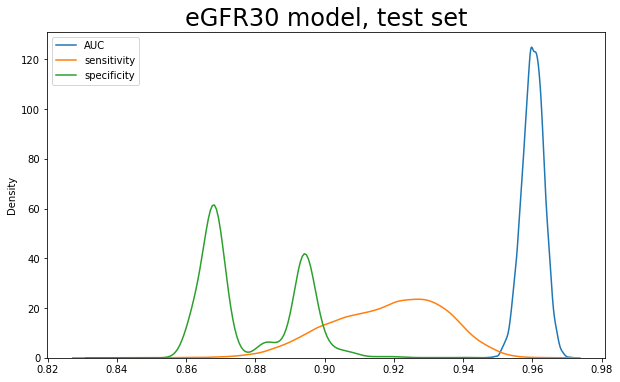

auc mean: 0.96 (0.95-0.97), median:0.96
se  mean: 0.92 (0.89-0.95), median:0.92
sp  mean: 0.88 (0.86-0.90), median:0.87
th  mean: 0.42 (0.38-0.50), median:0.40


In [16]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box, label='AUC') 
sns.kdeplot(se_box, label='sensitivity')
sns.kdeplot(sp_box, label='specificity')
plt.title("eGFR30 model, test set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box), lower_auc, upper_auc, np.median(auc_box)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box), lower_se, upper_se, np.median(se_box)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box), lower_sp, upper_sp, np.median(sp_box)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box), lower_th, upper_th, np.median(th_box)))

### external bootstrap

In [44]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv")
ev_wt = ev_wt.query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['leucocyte'] = np.nan
ev['eGFR_ab30'] = np.where(ev['eGFR_ckd']<30,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab30']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features_ev[std_cols]
X_test_features_ev[std_cols]=scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=126, ratio=0.20
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.049868,-0.525858,0.579458,0.094305,0.117039,0.142661
std,0.497665,0.784876,1.006370,1.027015,0.539820,0.409067,1.030256
min,0.000000,-1.723133,-1.435462,0.000000,0.000000,0.000000,-1.874471
25%,0.000000,-0.459250,-1.435462,0.000000,0.000000,0.000000,-0.653776
50%,0.000000,0.172692,-0.828272,0.000000,0.000000,0.000000,0.181436
75%,1.000000,0.804634,0.386109,1.000000,0.000000,0.000000,0.952401
max,1.000000,1.436575,3.422061,5.000000,5.000000,5.000000,2.044602


In [18]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
X_test_bs_ev = ev.copy()
X_test_bs_ev['prob'] = y_prob_ev
X_test_bs_ev

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,...,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,eGFR_ab30,wt,prob
210862,A901021301,0,76.36104,1,78,5.5,0,1.020,0,0,...,0,0,0,NaN,knhanes,0,0,0,320.734691,0.445728
210863,A901021302,0,90.97259,0,75,6.0,0,1.025,0,0,...,0,0,0,NaN,knhanes,0,0,0,456.006780,0.230785
210864,A901022601,0,106.45850,0,43,6.0,0,1.020,0,0,...,0,0,0,NaN,knhanes,0,0,0,592.556654,0.022357
210865,A901023304,0,85.96295,0,71,6.0,0,1.020,0,4,...,0,0,0,NaN,knhanes,0,0,0,288.311428,0.306590
210866,A901023502,0,110.41680,0,42,8.5,0,1.020,0,0,...,0,0,0,NaN,knhanes,0,0,0,592.556654,0.014834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273802,P549819801,0,75.12561,0,74,5.0,0,1.025,0,0,...,0,4,0,NaN,knhanes,0,0,0,108.891200,0.743937
273803,P549879801,0,71.56396,1,75,5.0,0,1.025,0,0,...,0,2,0,NaN,knhanes,0,0,0,201.759400,0.634476
273804,P549879802,0,66.76084,0,74,5.0,0,1.015,0,0,...,0,1,0,NaN,knhanes,0,0,0,163.336800,0.794004
273805,P549980702,0,90.97181,0,34,5.0,0,1.030,0,0,...,0,1,0,NaN,knhanes,0,0,0,232.329500,0.036820


In [20]:
# load dataset
data = X_test_bs_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_ev = []
th_box_ev = []
se_box_ev = []
sp_box_ev = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'], sample_weight=boot['wt'])
    
    auc_box_ev.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'], sample_weight=boot['wt'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_ev.append(best_thresh)
    se_box_ev.append(se)
    sp_box_ev.append(sp)

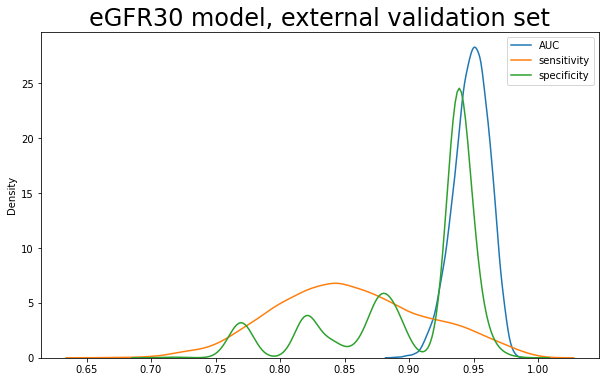

auc mean: 0.95 (0.92-0.97), median:0.95
se  mean: 0.85 (0.75-0.97), median:0.85
sp  mean: 0.90 (0.77-0.95), median:0.94
th  mean: 0.46 (0.21-0.60), median:0.53


In [21]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_ev, label='AUC') 
sns.kdeplot(se_box_ev, label='sensitivity')
sns.kdeplot(sp_box_ev, label='specificity')
plt.title("eGFR30 model, external validation set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_ev, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_ev), lower_auc, upper_auc, np.median(auc_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_ev, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_ev), lower_se, upper_se, np.median(se_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_ev, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_ev), lower_sp, upper_sp, np.median(sp_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_ev, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_ev), lower_th, upper_th, np.median(th_box_ev)))

### ROC

#### internal

eGFR30 model

Classification Report

Best Threshold=0.389, sensitivity = 0.93, specificity = 0.87, J=0.794
              precision    recall  f1-score   support

      normal       1.00      0.87      0.93     43387
    abnormal       0.09      0.93      0.16       618

    accuracy                           0.87     44005
   macro avg       0.54      0.90      0.55     44005
weighted avg       0.99      0.87      0.92     44005



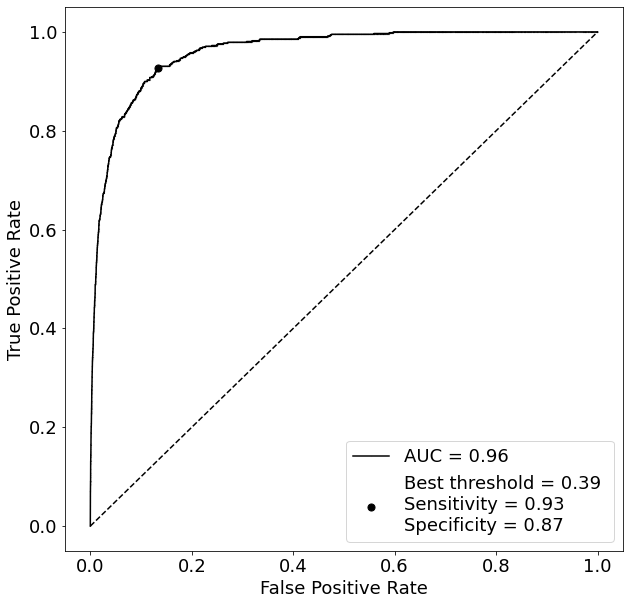

In [50]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_bs['prob']
y_test = X_test_bs['eGFR_ab30']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('eGFR30 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### external

eGFR30 model, knhanes, external validation

Classification Report

Best Threshold=0.531, sensitivity = 0.81, specificity = 0.94, J=0.748
              precision    recall  f1-score   support

      normal       1.00      0.94      0.97 35414313.94542637
    abnormal       0.02      0.81      0.04 55484.93117574184

    accuracy                           0.94 35469798.876602106
   macro avg       0.51      0.87      0.50 35469798.876602106
weighted avg       1.00      0.94      0.97 35469798.876602106



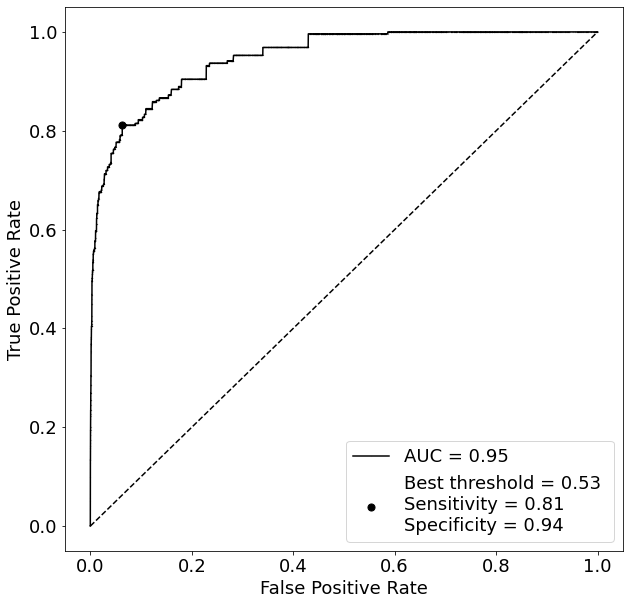

In [51]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]

print('eGFR30 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev >= best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### both internal and external

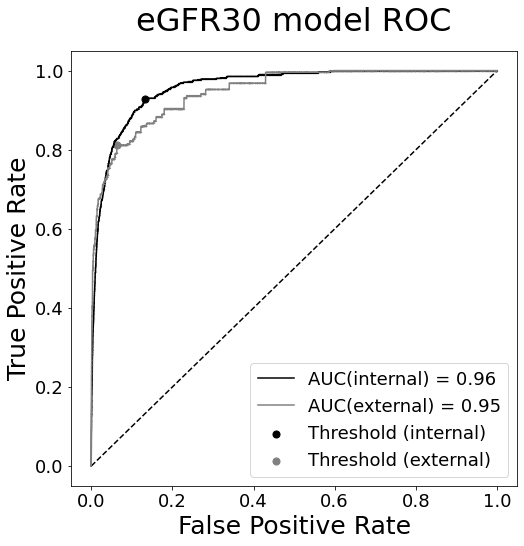

In [52]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-spec, sens, marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-spec_ev, sens_ev, marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR30 model ROC', size=32, pad=20)
# show the plot
#plt.show()

# save as png
plt.savefig('/home/danssa/proj_ua/images/new_4sub/30model_roc_sub1.png', dpi=300)

# SHAP value

In [25]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 175979/176015 [27:00<00:00]        

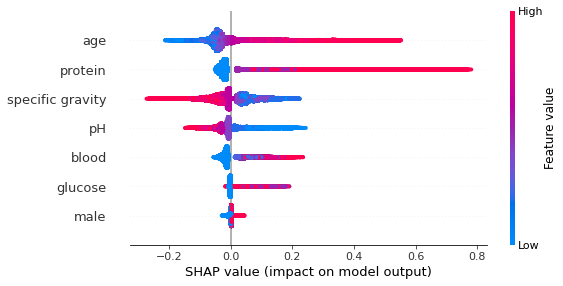

In [26]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [27]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [28]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 43955/44005 [06:45<00:00]        

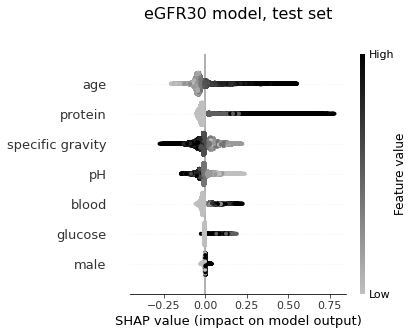

In [53]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR30 model, test set', fontsize=16, pad=35)
plt.tight_layout()

#save as png
plt.savefig('/home/danssa/proj_ua/images/new_4sub/30model_shap.png', dpi=300)

# sub group analysis, internal : DM, HTN, old age, proteinuria

In [30]:
# subset each group
X_test_g1 = X_test_bs.query('dm==1')
X_test_g2 = X_test_bs.query('htn==1')
X_test_g3 = X_test_bs.query('age>=65')
X_test_g4 = X_test_bs.query('he_upro>1')

In [31]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (len(X_test_g1), sum(X_test_g1['eGFR_ab30'])/len(X_test_g1)*100, sum(X_test_g1['eGFR_ab30'])))
print('group2: %d, %.1f (%d)' % (len(X_test_g2), sum(X_test_g2['eGFR_ab30'])/len(X_test_g2)*100, sum(X_test_g2['eGFR_ab30'])))
print('group3: %d, %.1f (%d)' % (len(X_test_g3), sum(X_test_g3['eGFR_ab30'])/len(X_test_g3)*100, sum(X_test_g3['eGFR_ab30'])))
print('group4: %d, %.1f (%d)' % (len(X_test_g4), sum(X_test_g4['eGFR_ab30'])/len(X_test_g4)*100, sum(X_test_g4['eGFR_ab30'])))

total cases, prevalence (cases)
group1: 1097, 1.1 (12)
group2: 1638, 0.4 (6)
group3: 7140, 5.1 (361)
group4: 3741, 10.9 (406)


## sub1 : DM

In [32]:
# test set
data = X_test_g1

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1 = []
th_box_s1 = []
se_box_s1 = []
sp_box_s1 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'])
    
    auc_box_s1.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s1.append(best_thresh)
    se_box_s1.append(se)
    sp_box_s1.append(sp)

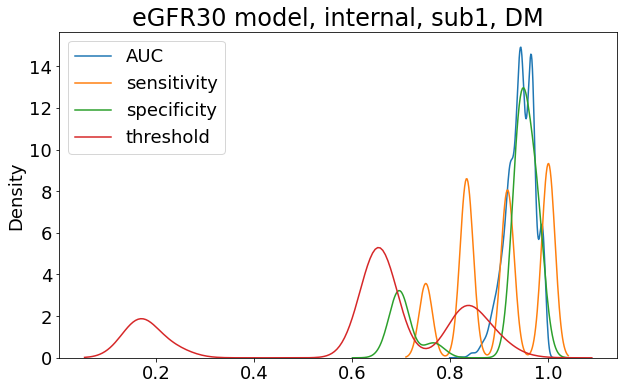

auc mean: 0.94 (0.88-0.99), median:0.95
se  mean: 0.90 (0.75-1.00), median:0.92
sp  mean: 0.90 (0.68-0.98), median:0.94
th  mean: 0.61 (0.17-0.88), median:0.65


In [33]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1, label='AUC') 
sns.kdeplot(se_box_s1, label='sensitivity')
sns.kdeplot(sp_box_s1, label='specificity')
sns.kdeplot(th_box_s1, label='threshold')
plt.title("eGFR30 model, internal, sub1, DM", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s1, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s1), lower_auc, upper_auc, np.median(auc_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s1, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s1), lower_se, upper_se, np.median(se_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s1, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s1), lower_sp, upper_sp, np.median(sp_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s1, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s1), lower_th, upper_th, np.median(th_box_s1)))

In [34]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1['prob']
y_test = X_test_g1['eGFR_ab30']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR30 model, group1')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR30 model, group1
AUC         : 0.94
sensitivity : 0.83
specificity : 0.94
Threshold   : 0.65

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.94      0.97      1085
    abnormal       0.14      0.83      0.24        12

    accuracy                           0.94      1097
   macro avg       0.57      0.89      0.60      1097
weighted avg       0.99      0.94      0.96      1097



## sub2 : HTN

In [35]:
# test set
data = X_test_g2

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2 = []
th_box_s2 = []
se_box_s2 = []
sp_box_s2 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'])
    
    auc_box_s2.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s2.append(best_thresh)
    se_box_s2.append(se)
    sp_box_s2.append(sp)

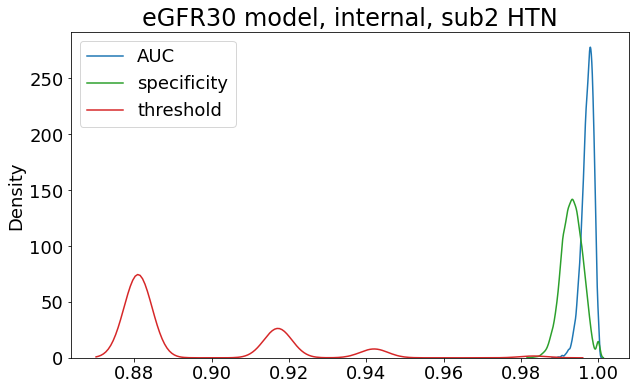

auc mean: 1.00 (0.99-1.00), median:1.00
se  mean: 1.00 (1.00-1.00), median:1.00
sp  mean: 0.99 (0.99-1.00), median:0.99
th  mean: 0.90 (0.88-0.94), median:0.88


In [36]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2, label='AUC') 
sns.kdeplot(se_box_s2, label='sensitivity')
sns.kdeplot(sp_box_s2, label='specificity')
sns.kdeplot(th_box_s2, label="threshold")
plt.title("eGFR30 model, internal, sub2 HTN", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s2, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s2), lower_auc, upper_auc, np.median(auc_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s2, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s2), lower_se, upper_se, np.median(se_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s2, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s2), lower_sp, upper_sp, np.median(sp_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s2, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s2), lower_th, upper_th, np.median(th_box_s2)))

In [37]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2['prob']
y_test = X_test_g2['eGFR_ab30']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR30 model, group2')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR30 model, group2
AUC         : 1.00
sensitivity : 1.00
specificity : 0.99
Threshold   : 0.88

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      1632
    abnormal       0.32      1.00      0.48         6

    accuracy                           0.99      1638
   macro avg       0.66      1.00      0.74      1638
weighted avg       1.00      0.99      0.99      1638



## sub3 : old age, age>=65

In [38]:
# test set
data = X_test_g3

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3 = []
th_box_s3 = []
se_box_s3 = []
sp_box_s3 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'])
    
    auc_box_s3.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s3.append(best_thresh)
    se_box_s3.append(se)
    sp_box_s3.append(sp)

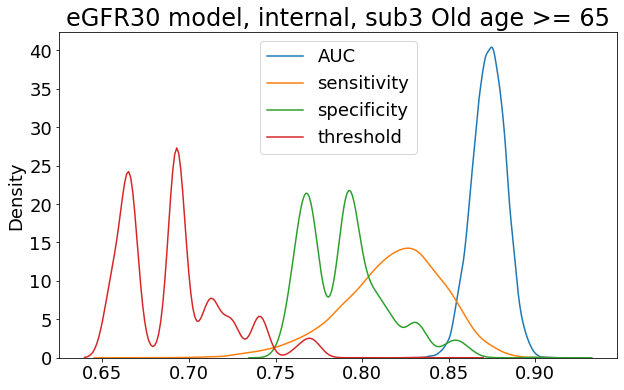

auc mean: 0.87 (0.85-0.89), median:0.87
se  mean: 0.82 (0.75-0.87), median:0.82
sp  mean: 0.79 (0.76-0.85), median:0.79
th  mean: 0.69 (0.65-0.77), median:0.69


In [39]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3, label='AUC') 
sns.kdeplot(se_box_s3, label='sensitivity')
sns.kdeplot(sp_box_s3, label='specificity')
sns.kdeplot(th_box_s3, label='threshold')
plt.title("eGFR30 model, internal, sub3 Old age >= 65", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s3, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s3), lower_auc, upper_auc, np.median(auc_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s3, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s3), lower_se, upper_se, np.median(se_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s3, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s3), lower_sp, upper_sp, np.median(sp_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s3, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s3), lower_th, upper_th, np.median(th_box_s3)))

In [40]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3['prob']
y_test = X_test_g3['eGFR_ab30']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR30 model, group3')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR30 model, group3
AUC         : 0.87
sensitivity : 0.81
specificity : 0.79
Threshold   : 0.69

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.79      0.88      6779
    abnormal       0.17      0.81      0.28       361

    accuracy                           0.79      7140
   macro avg       0.58      0.80      0.58      7140
weighted avg       0.95      0.79      0.85      7140



## sub4 : proteinuria

In [41]:
# test set
data = X_test_g4

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab30'])
    auc = roc_auc_score(boot['eGFR_ab30'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab30'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

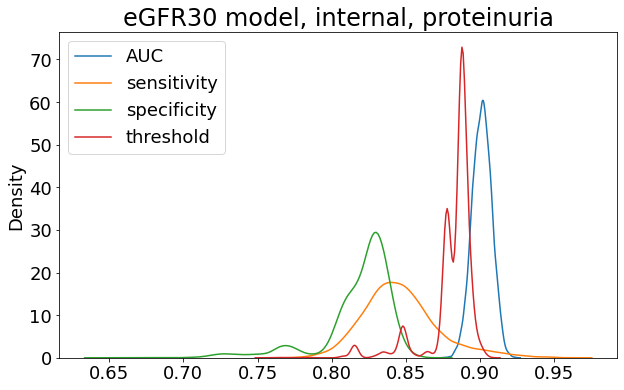

auc mean: 0.90 (0.89-0.91), median:0.90
se  mean: 0.85 (0.80-0.91), median:0.84
sp  mean: 0.82 (0.74-0.85), median:0.82
th  mean: 0.88 (0.83-0.90), median:0.89


In [42]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR30 model, internal, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [43]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4['prob']
y_test = X_test_g4['eGFR_ab30']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR30 model, group4')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR30 model, group4
AUC         : 0.90
sensitivity : 0.83
specificity : 0.83
Threshold   : 0.89

Classification Report

              precision    recall  f1-score   support

      normal       0.98      0.83      0.90      3335
    abnormal       0.37      0.83      0.51       406

    accuracy                           0.83      3741
   macro avg       0.67      0.83      0.70      3741
weighted avg       0.91      0.83      0.85      3741

